In [1]:
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer
from keras import backend as K
K.set_image_data_format('channels_first')
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
from fr_utils import *
from inceptionblock import *
import keras.backend.tensorflow_backend as tfback
print("tf.__version__ is", tf.__version__)
print("tf.keras.__version__ is:", tf.keras.__version__)

from gtts import gTTS 
from playsound import playsound   
# This module is imported so that we can  
# play the converted audio 
import os 

def sound(message):
# The text that you want to convert to audio 
    mytext = message
    language = 'en'
    myobj = gTTS(text=mytext, lang=language, slow=True) 
    myobj.save("welcomehere.mp3") 
    playsound("welcomehere.mp3")
    os.remove("welcomehere.mp3")
# Playing the converted file 


def _get_available_gpus():
    """Get a list of available gpu devices (formatted as strings).

    # Returns
        A list of available GPU devices.
    """
    #global _LOCAL_DEVICES
    if tfback._LOCAL_DEVICES is None:
        devices = tf.config.list_logical_devices()
        tfback._LOCAL_DEVICES = [x.name for x in devices]
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]

tfback._get_available_gpus = _get_available_gpus

%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


tf.__version__ is 2.1.0
tf.keras.__version__ is: 2.2.4-tf


In [2]:
FRmodel = faceRecoModel(input_shape=(3, 96, 96))

In [3]:
print("Total Params:", FRmodel.count_params())

Total Params: 3743280


In [4]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    """
    Implementation of the triplet loss as defined by formula (3)
    
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor images, of shape (None, 128)
            positive -- the encodings for the positive images, of shape (None, 128)
            negative -- the encodings for the negative images, of shape (None, 128)
    
    Returns:
    loss -- real number, value of the loss
    """
    
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    
    ### START CODE HERE ### (≈ 4 lines)
    # Step 1: Compute the (encoding) distance between the anchor and the positive
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,positive)),-1)
    # Step 2: Compute the (encoding) distance between the anchor and the negative
    neg_dist = tf.reduce_sum((tf.square(tf.subtract(anchor,negative))),-1)
    # Step 3: subtract the two previous distances and add alpha.
    basic_loss = tf.add(tf.subtract(pos_dist,neg_dist),alpha)
    # Step 4: Take the maximum of basic_loss and 0.0. Sum over the training examples.
    loss = tf.reduce_sum(tf.maximum(basic_loss,0))
    ### END CODE HERE ###
    
    return loss

In [5]:
FRmodel.compile(optimizer = 'adam', loss = triplet_loss, metrics = ['accuracy'])
load_weights_from_FaceNet(FRmodel)

In [6]:
import glob
database = {}
for file in glob.glob("train/*"):
    person_name = os.path.splitext(os.path.basename(file))[0]
    print(file)
    #image_file = cv2.imread(file, 1)
    database[person_name] = img_to_encoding(file,FRmodel) 

train\AlanTuring.jpg
train\Ali.jpg
train\allamaiqbal.jpg
train\AndrewNg.jpg
train\billgates.jpg
train\brocklesnar.jpg
train\goku.jpg
train\Hamza.jpg
train\Jawad.jpg
train\jhon.jpg
train\jhoncena.jpg
train\linus.jpg
train\Mccarthy.jpg
train\messi.jpg
train\Murtuza.jpg
train\quaid-e-azam.jpg
train\ronaldo.jpg
train\shahidafridi.jpg
train\stevejobs.jpg
train\vegeta.jpg


In [7]:
from PIL import Image  
import PIL  
# GRADED FUNCTION: who_is_it
def who_is_it(image_path, database, model):
    """
    Implements face recognition for the office by finding who is the person on the image_path image.
    
    Arguments:
    image_path -- path to an image
    database -- database containing image encodings along with the name of the person on the image
    model -- your Inception model instance in Keras
    
    Returns:
    min_dist -- the minimum distance between image_path encoding and the encodings from the database
    identity -- string, the name prediction for the person on image_path
    """
    
    ### START CODE HERE ### 
    
    ## Step 1: Compute the target "encoding" for the image. Use img_to_encoding() see example above. ## (≈ 1 line)
    encoding = img_to_encoding(image_path,model)
    
    ## Step 2: Find the closest encoding ##
    
    # Initialize "min_dist" to a large value, say 100 (≈1 line)
    min_dist = 100
    
    # Loop over the database dictionary's names and encodings.
    for (name, db_enc) in database.items():
        
        # Compute L2 distance between the target "encoding" and the current db_enc from the database. (≈ 1 line)
        dist = np.linalg.norm(db_enc - encoding)

        # If this distance is less than the min_dist, then set min_dist to dist, and identity to name. (≈ 3 lines)
        if dist < min_dist:
            min_dist = dist
            identity = name

    ### END CODE HERE ###
    
    if min_dist > 0.7:
        print("Not in the database.")
        print ( "the closest distance is " + str(min_dist)+" to  "+str(identity))
        playsound("dknow.mp3")
    else:
        print ("it's " + str(identity) + ", the distance is " + str(min_dist))
        playsound(str(identity) + ".mp3")
    img = Image.open(image_path)  
    plt.imshow(img)
    plt.show()
    return min_dist, identity,img

it's shahidafridi, the distance is 0.6453807


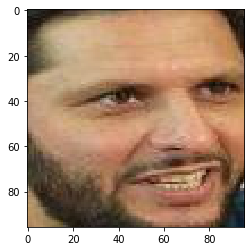

Not in the database.
the closest distance is 0.7321909 to  jhoncena


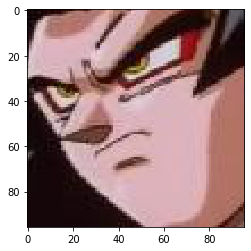

it's Mccarthy, the distance is 0.6149674


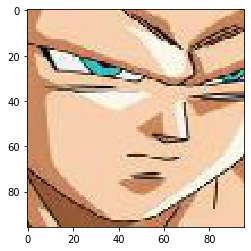

Not in the database.
the closest distance is 0.7611828 to  goku


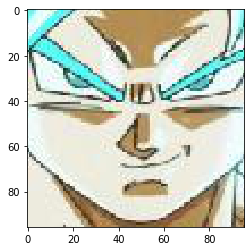

Not in the database.
the closest distance is 0.8308687 to  Hamza


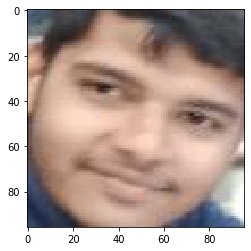

Not in the database.
the closest distance is 0.738826 to  jhoncena


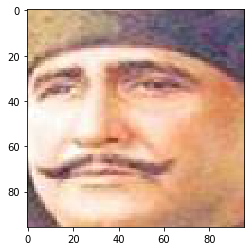

it's allamaiqbal, the distance is 0.6777425


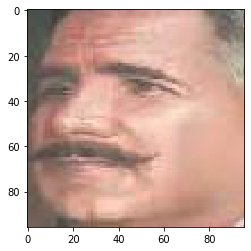

it's Ali, the distance is 0.60707086


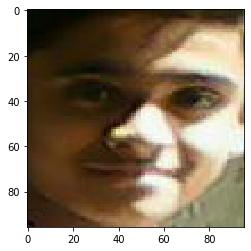

it's vegeta, the distance is 0.61850446


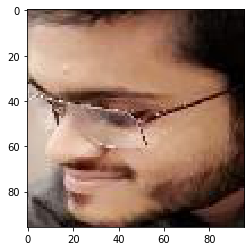

Not in the database.
the closest distance is 0.8018084 to  jhon


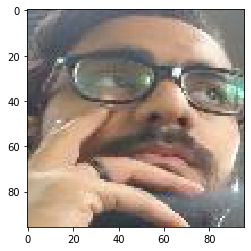

it's Jawad, the distance is 0.5998732


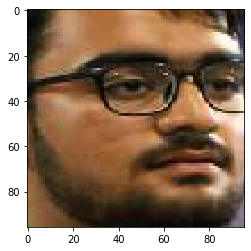

Not in the database.
the closest distance is 0.7201255 to  ronaldo


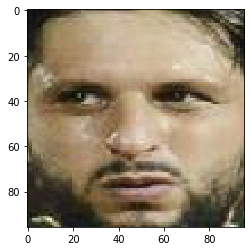

it's ronaldo, the distance is 0.5415972


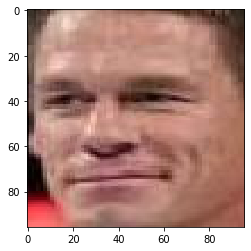

Not in the database.
the closest distance is 0.7401784 to  ronaldo


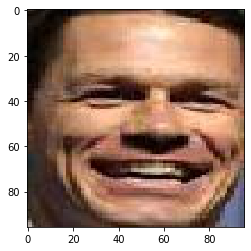

it's allamaiqbal, the distance is 0.6953541


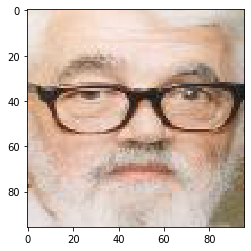

Not in the database.
the closest distance is 0.74177796 to  messi


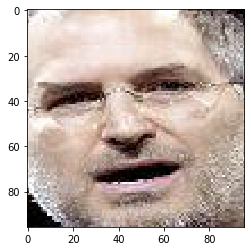

it's stevejobs, the distance is 0.645159


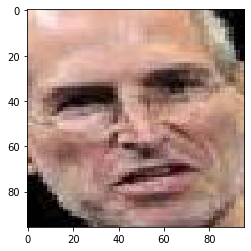

Not in the database.
the closest distance is 0.7602699 to  linus


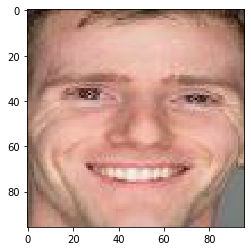

Not in the database.
the closest distance is 0.7892508 to  linus


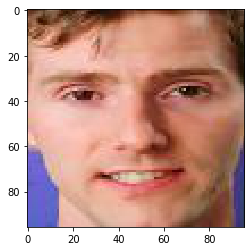

Not in the database.
the closest distance is 0.80896896 to  Ali


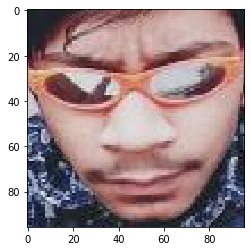

it's jhon, the distance is 0.5694129


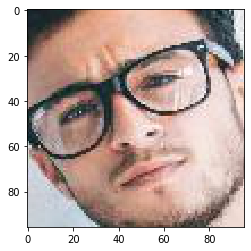

Not in the database.
the closest distance is 0.7766626 to  AlanTuring


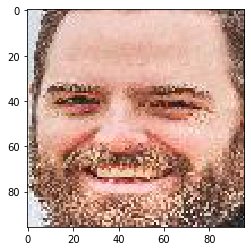

it's AndrewNg, the distance is 0.5455907


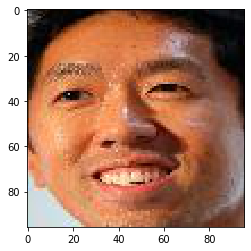

it's allamaiqbal, the distance is 0.6345363


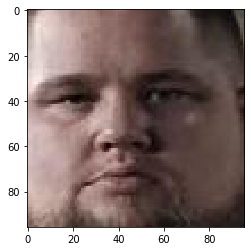

it's Mccarthy, the distance is 0.636476


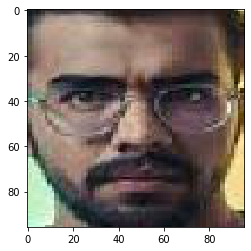

it's shahidafridi, the distance is 0.6331494


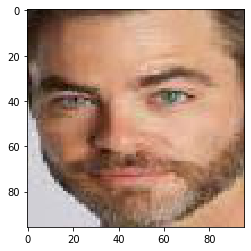

it's Mccarthy, the distance is 0.6195477


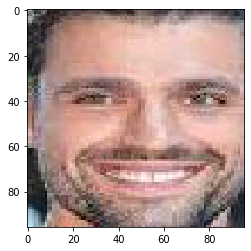

Not in the database.
the closest distance is 0.95589596 to  AlanTuring


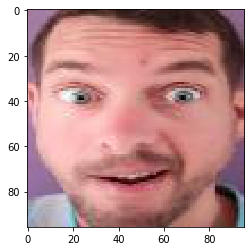

it's Hamza, the distance is 0.6936996


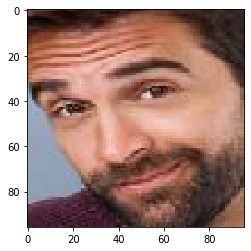

it's goku, the distance is 0.66719323


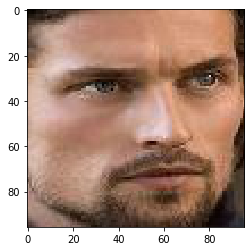

Not in the database.
the closest distance is 0.77527434 to  Ali


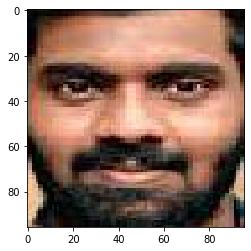

it's AlanTuring, the distance is 0.59348834


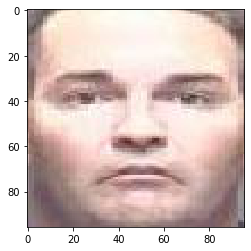

it's shahidafridi, the distance is 0.56187475


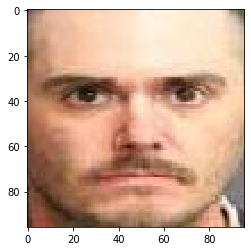

it's AndrewNg, the distance is 0.5103576


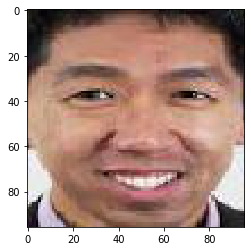

Not in the database.
the closest distance is 0.8188443 to  AlanTuring


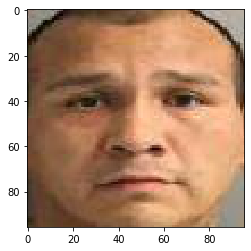

Not in the database.
the closest distance is 0.8236848 to  messi


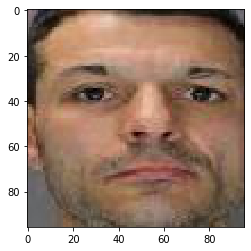

it's Murtuza, the distance is 0.63473606


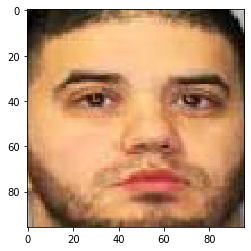

Not in the database.
the closest distance is 0.8369081 to  Mccarthy


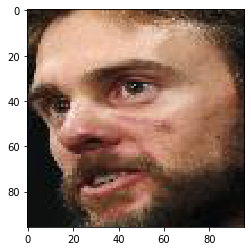

it's allamaiqbal, the distance is 0.6755457


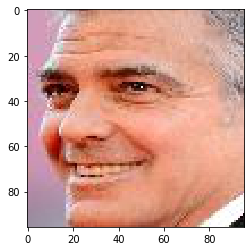

Not in the database.
the closest distance is 0.827735 to  shahidafridi


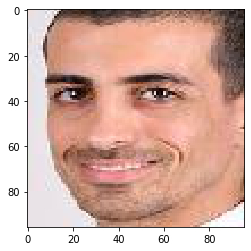

Not in the database.
the closest distance is 0.8605073 to  Hamza


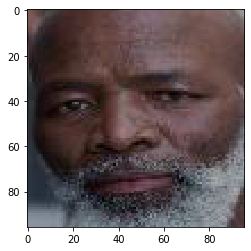

it's Mccarthy, the distance is 0.5651406


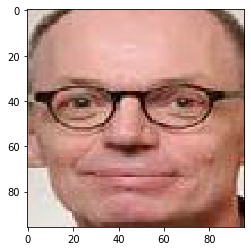

Not in the database.
the closest distance is 0.7050269 to  AlanTuring


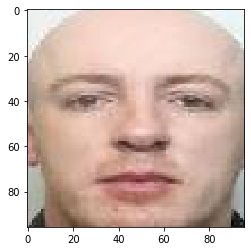

Not in the database.
the closest distance is 0.7837066 to  shahidafridi


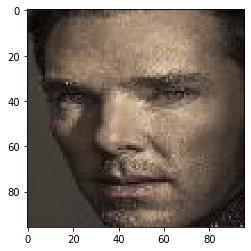

Not in the database.
the closest distance is 0.71804476 to  linus


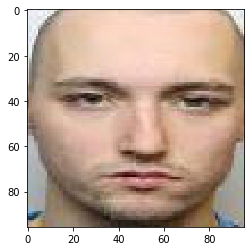

Not in the database.
the closest distance is 0.8138076 to  allamaiqbal


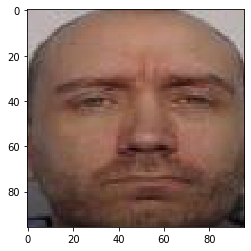

Not in the database.
the closest distance is 0.7622364 to  shahidafridi


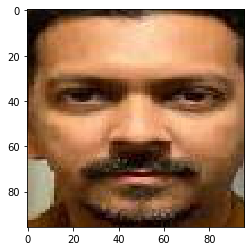

Not in the database.
the closest distance is 0.773007 to  Mccarthy


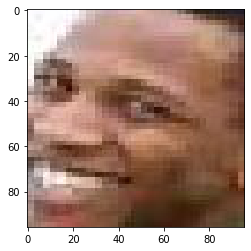

Not in the database.
the closest distance is 0.78634924 to  vegeta


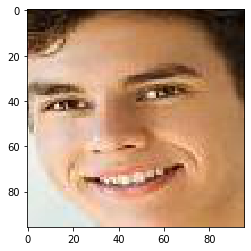

it's brocklesnar, the distance is 0.6998294


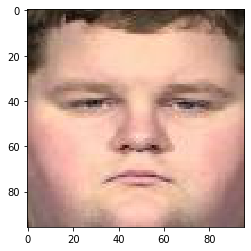

Not in the database.
the closest distance is 0.7124822 to  AlanTuring


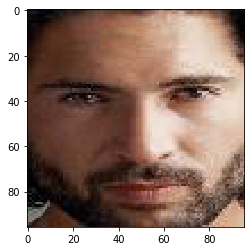

Not in the database.
the closest distance is 0.7853076 to  messi


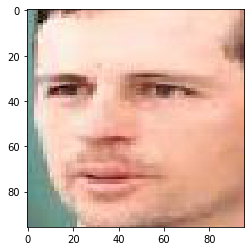

Not in the database.
the closest distance is 0.8415432 to  Ali


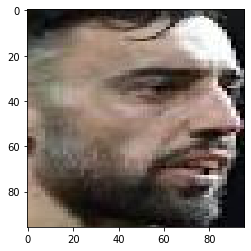

it's stevejobs, the distance is 0.65976435


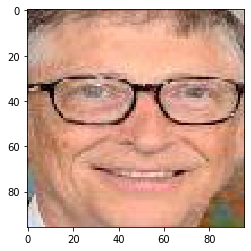

Not in the database.
the closest distance is 0.724173 to  ronaldo


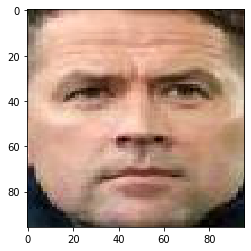

Not in the database.
the closest distance is 0.7993492 to  Ali


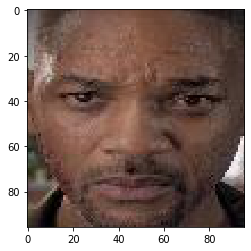

it's allamaiqbal, the distance is 0.63726544


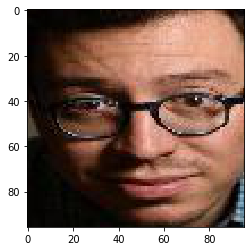

it's ronaldo, the distance is 0.6229325


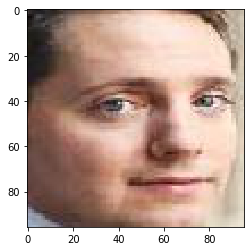

Not in the database.
the closest distance is 0.8342509 to  allamaiqbal


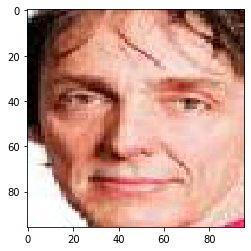

it's Hamza, the distance is 0.60274994


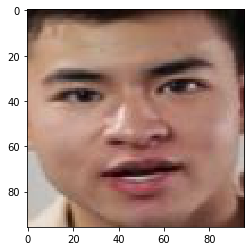

it's ronaldo, the distance is 0.648034


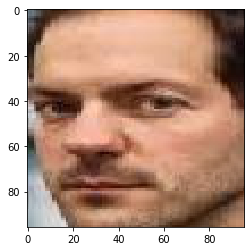

it's shahidafridi, the distance is 0.46108684


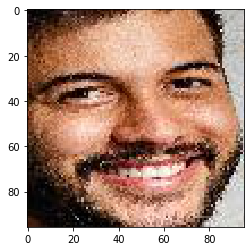

Not in the database.
the closest distance is 0.9034556 to  shahidafridi


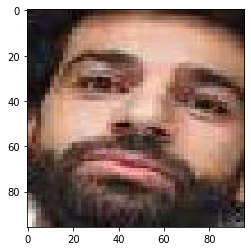

Not in the database.
the closest distance is 0.7717121 to  jhon


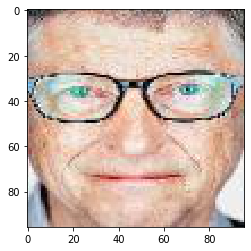

it's goku, the distance is 0.6606849


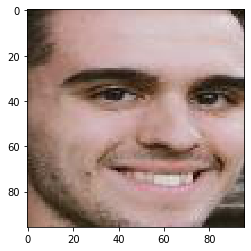

Not in the database.
the closest distance is 0.7748328 to  messi


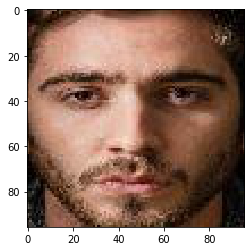

it's jhon, the distance is 0.6386599


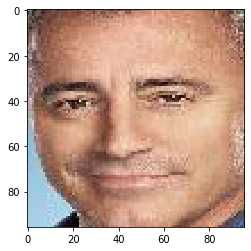

Not in the database.
the closest distance is 0.8661549 to  messi


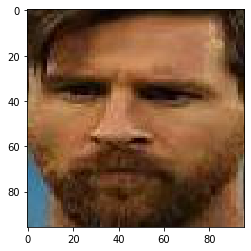

it's messi, the distance is 0.5488935


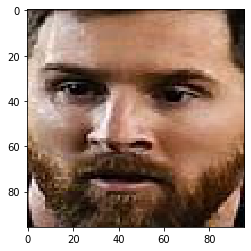

it's Hamza, the distance is 0.48387304


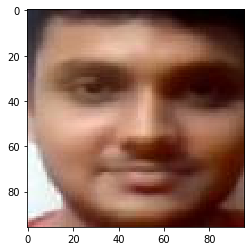

it's Ali, the distance is 0.65245533


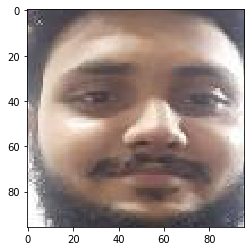

Not in the database.
the closest distance is 0.8107055 to  AlanTuring


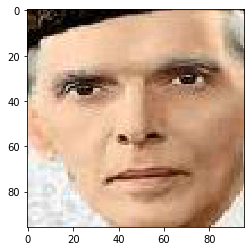

Not in the database.
the closest distance is 0.7619004 to  jhoncena


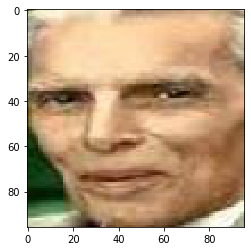

it's Jawad, the distance is 0.6117969


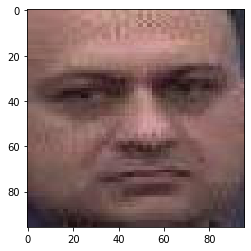

it's Jawad, the distance is 0.5122945


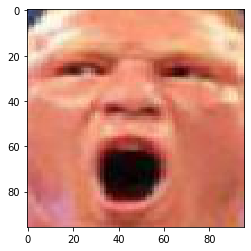

Not in the database.
the closest distance is 0.79275966 to  ronaldo


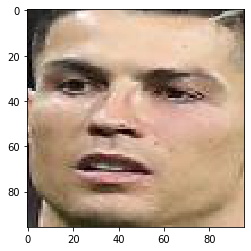

it's goku, the distance is 0.4784162


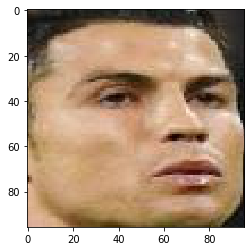

it's AlanTuring, the distance is 0.5965598


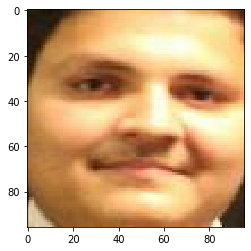

Not in the database.
the closest distance is 0.7158182 to  Jawad


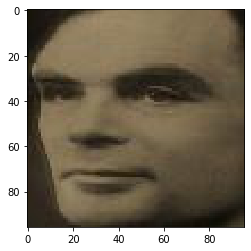

Not in the database.
the closest distance is 0.8563248 to  billgates


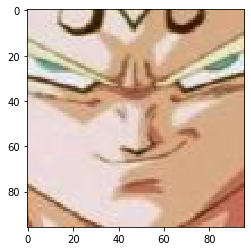

it's Mccarthy, the distance is 0.6037876


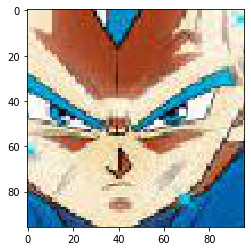

it's Mccarthy, the distance is 0.4661544


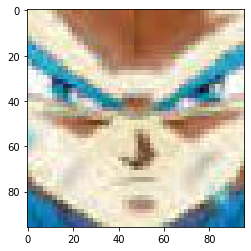

it's Ali, the distance is 0.56437826


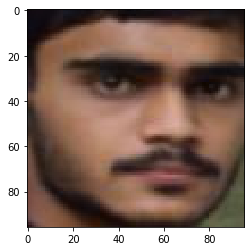

it's brocklesnar, the distance is 0.5982861


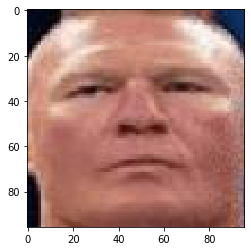

In [8]:
import glob
for file in glob.glob("test/*"):
    who_is_it(file,database,FRmodel)

In [31]:
9

In [34]:
FRmodel.evaluate()

TypeError: 'list' object is not callable